In [ ]:
!pip install datasets transformers rouge-score nltk rouge_chinese

In [2]:
import json
# 定义一个空列表用于存储所有的字典
train_list = []
test_list = []
# 打开JSON Lines文件
with open('dureadqg/train.json', 'r') as file:
    # 逐行读取
    for line in file:
        # 解析每一行
        data_dict = json.loads(line)
        # 将解析后的字典添加到列表中
        if len(data_dict['context']) + len(data_dict['question'])  > 512:
            continue
        train_list.append(data_dict)
# 打开JSON Lines文件
with open('dureadqg/dev.json', 'r') as file:
    # 逐行读取
    for line in file:
        # 解析每一行
        data_dict = json.loads(line)
        # 将解析后的字典添加到列表中

        test_list.append(data_dict)
from datasets import *
train_dataset = Dataset.from_list(train_list)
test_dataset = Dataset.from_list(test_list)
print(train_dataset, test_dataset)

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['context', 'answer', 'question', 'id'],
    num_rows: 12675
}) Dataset({
    features: ['context', 'answer', 'question', 'id'],
    num_rows: 984
})


In [3]:
from modelscope import HubApi
from modelscope import snapshot_download

# api=HubApi()
# api.login('49834fc2-f98f-4ac3-8efc-01ce1764baf8')

# download your model, the model_path is downloaded model path.
model_path =snapshot_download(model_id="langboat/mengzi-t5-base")

2024-07-24 17:08:29,189 - modelscope - INFO - PyTorch version 2.0.1+cu118 Found.
2024-07-24 17:08:29,191 - modelscope - INFO - TensorFlow version 2.13.0 Found.
2024-07-24 17:08:29,192 - modelscope - INFO - Loading ast index from /mnt/workspace/.cache/modelscope/ast_indexer
2024-07-24 17:08:29,218 - modelscope - INFO - Loading done! Current index file version is 1.9.5, with md5 e096d041fdba41d8d7d7331b3f469288 and a total number of 945 components indexed
2024-07-24 17:08:29,220 - modelscope - WARNING - Authentication has expired, please re-login if you need to access private models or datasets.
2024-07-24 17:08:29,891 - modelscope - WARNING - Model revision not specified, use revision: v1.0.0


In [4]:
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments
tokenizer = AutoTokenizer.from_pretrained(model_path)
def process_func(exmaples):

    qc = ["根据文本内容来回答问题\n问题: \n" + q + "\n文本内容: \n" + c for q, c in zip(exmaples['question'], exmaples['context'])]
    inputs = tokenizer(qc, max_length=512, truncation=True)
    labels = tokenizer(text_target=exmaples["answer"], max_length=64, truncation=True)
    inputs["labels"] = labels["input_ids"]
    return inputs

train_tokenized_ds = train_dataset.map(process_func, batched=True)
test_tokenized_ds = test_dataset.map(process_func, batched=True)

2024-07-24 17:08:30.776456: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-24 17:08:30.816622: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 17:08:31.575331: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the n

In [5]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

In [6]:
import numpy as np
from rouge_chinese import Rouge
from nltk.translate.bleu_score import sentence_bleu
import numpy as np

rouge = Rouge()

def compute_metric(evalPred):
    def calculate_bleu_scores(candidate, references):
        candidate = list(candidate.split(" "))
        reference = [list(references.split(" "))]
        weights_list = [
            (1, 0, 0, 0),   # BLEU-1
            (0.5, 0.5, 0, 0),   # BLEU-2
            (1/3, 1/3, 1/3, 0),   # BLEU-3
            (0.25, 0.25, 0.25, 0.25) # BLEU-4
        ]

        bleu_scores = []
        for weights in weights_list:
            # print(sentence_bleu(reference, candidate, weights=weights))
            score = sentence_bleu(reference, candidate, weights=weights)
            bleu_scores.append(score)
        return bleu_scores
    predictions, labels = evalPred
    decode_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decode_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decode_preds = [" ".join(p) for p in decode_preds]
    decode_labels = [" ".join(l) for l in decode_labels]
    # rouge_scores = rouge.get_scores(decode_preds, decode_labels, avg=True)
    bleu_scores_batch = np.mean(np.array([calculate_bleu_scores(cand, refs) for cand, refs in zip(decode_preds, decode_labels)]), axis=0)
    return {
        # "rouge-1": rouge_scores["rouge-1"]["f"],
        # "rouge-2": rouge_scores["rouge-2"]["f"],
        # "rouge-l": rouge_scores["rouge-l"]["f"],
        "bleu-l": bleu_scores_batch[0],
        "bleu-2": bleu_scores_batch[1],
        "bleu-3": bleu_scores_batch[2],
        "bleu-4": bleu_scores_batch[3],
    }

In [7]:
import matplotlib.pyplot as plt
from transformers import Seq2SeqTrainingArguments, TrainerCallback
from transformers.trainer_utils import TrainOutput

args = Seq2SeqTrainingArguments(
    output_dir="./summary_qa",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    evaluation_strategy='steps',
    save_strategy="steps",
    save_steps=100,
    metric_for_best_model="bleu-l",
    predict_with_generate=True,
    fp16=False,
    save_total_limit=2,
    num_train_epochs = 4,
    lr_scheduler_type='linear',
    warmup_steps=100,
    optim='adamw_torch',
    seed = 42,
)
trainer = Seq2SeqTrainer(
    args=args,
    model=model,
    train_dataset=train_tokenized_ds,
    eval_dataset=test_tokenized_ds,
    compute_metrics=compute_metric,
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer)
)

In [8]:
torch.cuda.empty_cache()
trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Bleu-l,Bleu-2,Bleu-3,Bleu-4
50,6.383600,2.071031,0.268683,0.222958,0.172757,0.130448
100,1.498400,1.061076,0.565069,0.524035,0.429529,0.355713
150,0.905700,0.909657,0.635274,0.598156,0.507818,0.428007
200,0.831900,0.916335,0.648162,0.613830,0.512660,0.426493
250,0.714800,0.838330,0.667343,0.629915,0.527217,0.441664
300,0.688800,0.848442,0.663806,0.626644,0.524067,0.437685
350,0.636500,0.779770,0.680494,0.643626,0.537957,0.454425
400,0.606000,0.806124,0.688006,0.654123,0.544869,0.463129
450,0.450200,0.815926,0.691093,0.656792,0.548870,0.465579
500,0.447400,0.841847,0.691301,0.657770,0.547887,0.463164


/opt/conda/lib/python3.8/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.8/site-packages/nltk/transla

TrainOutput(global_step=1584, training_loss=0.6399185585253166, metrics={'train_runtime': 2474.9682, 'train_samples_per_second': 20.485, 'train_steps_per_second': 0.64, 'total_flos': 1.874631315596083e+16, 'train_loss': 0.6399185585253166, 'epoch': 4.0})

In [10]:
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
event_file_path = 'summary_qa/runs/Jul24_17-08-37_dsw-584084-54b5bd5897-ddk5q/events.out.tfevents.1721812119.dsw-584084-54b5bd5897-ddk5q.7946.0'

ea = EventAccumulator(event_file_path)
ea.Reload()
train_loss_metric_data = {}
rel_name_need = ['train/loss', 'eval/loss', 'eval/bleu-l', 'eval/bleu-2', 'eval/bleu-3', 'eval/bleu-4']
for tag in ea.Tags()['scalars']:
    # print(tag, '\n')
    if tag not in rel_name_need:
        continue
    train_loss_metric_data[tag] = []
    for scalar_event in ea.Scalars(tag):
        # print(scalar_event.wall_time)
        train_loss_metric_data[tag].append(scalar_event.value)
print(train_loss_metric_data.keys())

dict_keys(['train/loss', 'eval/loss', 'eval/bleu-l', 'eval/bleu-2', 'eval/bleu-3', 'eval/bleu-4'])


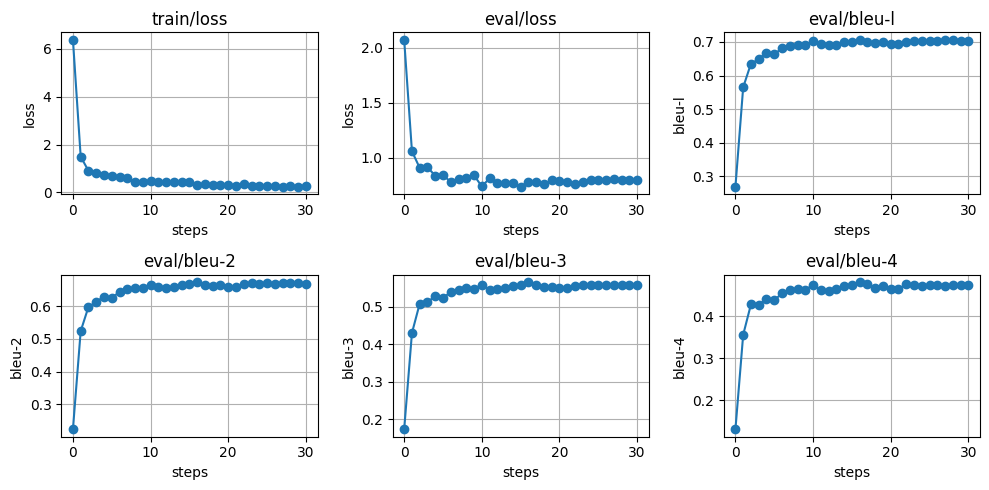

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 创建一个新的figure对象，设置其大小
fig, axs = plt.subplots(2, 3, figsize=(10, 5))
# if not isinstance(axs, np.ndarray):
#     axs = [axs]
# 遍历数据字典中的每个键值对
for i, (key, values) in enumerate(train_loss_metric_data.items()):
    row = i // 3  # 计算行索引
    col = i % 3   # 计算列索引
    # 在相应的子图上绘制数据
    # print(values)
    axs[row, col].plot(range(len(values)), values, 'o-')
    axs[row, col].set_title(key)  # 设置子图标题
    axs[row, col].set_xlabel('steps')  # 设置x轴标签
    axs[row, col].set_ylabel(key.split('/')[1])  # 设置y轴标签
    axs[row, col].grid(True)

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

In [12]:
from transformers import pipeline
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments
model_dir = './summary_qa/checkpoint-1500'
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)

In [13]:
pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer, device=0)

In [14]:
ids = 10
print("根据文本内容来回答问题\n问题: \n" + test_dataset[ids]["question"] + "\n文本内容: \n" + test_dataset[ids]["context"])
pipe("根据文本内容来回答问题\n问题: \n" + test_dataset[ids]["question"] + "\n文本内容: \n" + test_dataset[ids]["context"], max_length=512, do_sample=True)

根据文本内容来回答问题
问题: 
mi是美国哪个州的缩写
文本内容: 
密歇根州。地理位置：密歇根州（Michigan）位于美国最北部，由两大半岛组成，分隔两半岛的水面叫做麦基诺水道。南为下半岛，是该州的主体，面积较大，其南境西半部接印第安纳州，东半部接俄亥俄州。半岛西、北、东三方面均为湖泊，西、北为密歇根湖，东北为休伦湖，东为圣克莱尔湖与圣克莱尔河，东南是伊利湖。北部为上半岛，面积比下半岛小，北滨苏必利尔湖，南临密歇根湖，西南邻威斯康星州，东端为圣马里斯河及苏运河。气候与面积：州面积250,493平方公里，居美国50州第11位。位于五大湖区，受湖风调剂，气候温和。北方的苏圣玛丽城平均最高温度为10℃，平均最低温度为-1℃。东南部的底特律市平均最高温度为14℃，平均最低温度为6℃。上半岛的生长期约为3个月，而下半岛的南部地区长达6个月。年平均降水量838毫米，南部较多，达914毫米。城市与人口：人口987.6万（2011年），居全美第8位，白人占总人口的79.6%，黑人占14%。密州有83个郡，州府兰辛市（Lansing），人口11.6万，为州政治、文化及教育中心。底特律（Detroit）是密州最大城市，人口87万。大底特律地区华侨华人较为集中。历史：17世纪时为印第安人居住地，1668年法国殖民者建立第一个定居点，1701年底特律成为皮毛贸易中心，1783年以后归属美国。1837年加入联邦，成为美国第26个州。


[{'generated_text': '密歇根州'}]

In [15]:
test_dataset[ids]["answer"]

'Michigan'